In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Net_Visualizer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME

!git config --global user.email 'arjun2000ashok@gmail.com'
!git config --global user.name 'Arjun Ashok'

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/My Drive/Net_Visualizer


# Git

In [34]:
!git add .
!git commit -m 'Done with saliency, to transfer'
!git push -u origin master

[master 2f01325] Done with saliency, to transfer
 5 files changed, 71 insertions(+), 1 deletion(-)
 delete mode 100644 data/get_imagenet_val.sh
 create mode 100644 data/imagenet_val_25.npz
 create mode 100644 utils.py
 rewrite visualizer.ipynb (78%)
Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (7/7), 3.13 MiB | 1.59 MiB/s, done.
Total 7 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/aiarjun/Network-Visualizer.git
   2d261d7..2f01325  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


# Code testing

## Saliency map

A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. 

To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. 


To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

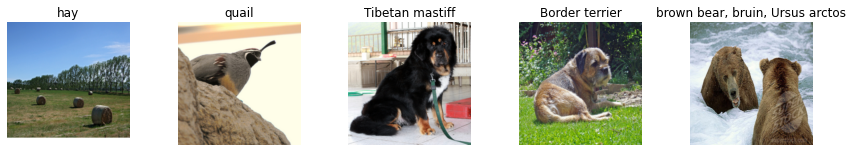

In [4]:
from utils import *
X, y, idx2label = load_imagenet_val(count=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(idx2label[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [32]:
model = get_pretrained_squeezenet()
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

model.eval()
X_tensor.requires_grad_()

scores = model(X_tensor)
correct_label_scores = (scores.gather(1, y_tensor.view(-1, 1)).squeeze())
correct_label_scores.backward(torch.FloatTensor([1.0]*correct_label_scores.shape[0]))

saliency, _ = torch.max(X_tensor.grad.data.abs(), axis = 1)

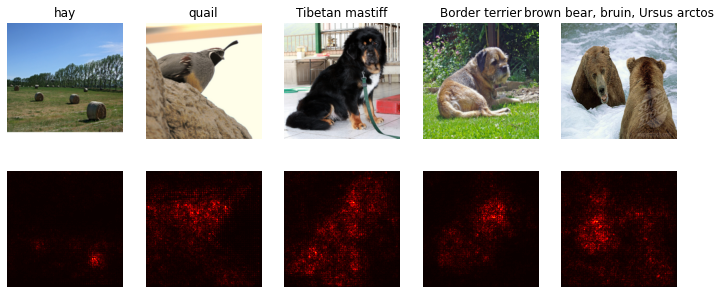

In [33]:
saliency = saliency.numpy()
N = X.shape[0]
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(idx2label[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

# Adversarial Fooling

We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [36]:
def make_fooling_image(X, target_y, model):
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    learning_rate = 1
    iter = 0
    print_every = 10

    while True:
        scores = model(X_fooling)
        _, idx = torch.max(scores, 1)
        if (idx != target_y):
            scores[:,target_y].backward()
            dX = learning_rate*X_fooling.grad.data/torch.norm(X_fooling.grad.data)
            X_fooling.data += dX.data
            X_fooling.grad.data.zero_()
            if iter % print_every == 0:         
              print('Iteration %d, target indices\' scores: ' % (iter), scores[:,target_y].data)
            iter += 1
        else:
            break 
    return X_fooling

In [49]:
idx = 0
target_y = 100

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Iteration 0, target indices' scores:  tensor([10.2933])


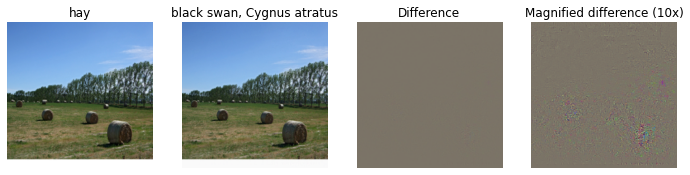

In [50]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(idx2label[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(idx2label[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class visualization